<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-probability

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
tf.enable_eager_execution()

In [0]:
tfe = tf.contrib.eager
tfd = tfp.distributions
ed = tfp.edward2

### データの生成
ある少数の成分はただのガウスノイズ。ほかはsin波形かcos波形であるような多次元信号を生成します。このような設定にしていることには意味があるので、覚えておいてください。


In [0]:
def toy_data(N, D):
    t = np.linspace(-np.pi, np.pi, N)
    def random_choice_wave():
        random_value = np.random.randn()
        if random_value < -0.9:
            ## ガウスノイズを発生
            return lambda x: 0.5*np.random.randn(N)
        elif random_value < 0:
            return np.cos
        else:
            return np.sin
    X = [random_choice_wave()(2*np.pi*t)+0.3*np.random.randn(N) for _ in range(D)]
    return np.array(X).transpose(1, 0)

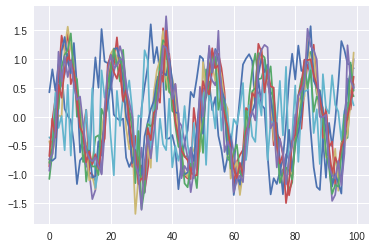

In [0]:
X = toy_data(100, 10)
plt.plot(X)

### 主成分分析
平均が$0$になるように座標の平行移動が行われた後の観測データ を$\bf x_i \in \mathcal R^D $とします（この作業は単に成分毎に平均を求めてデータから減産すれば良い）。このデータを並べた行列を $\bf X = (x_1, \cdots, x_N)^T$ としましょう（すなわち $\bf X \in \mathcal R^{N\times D}$となっています）。主成分分析は観測データの分散共分散行列 $\bf V_x = X^T X \in \mathcal R^{D\times D}$ を固有値分解することで実施することができます。分散共分散行列は対称行列なので、適当な直交行列 $\bf U$ を使って、

$$
\bf V_x = U\Lambda U^T
$$
 
と固有値分解できます。ここで $\bf \Lambda =diag(\lambda_1,\cdots ,\lambda_D) $ です。$\lambda_i$は固有値です（縮退も含めれば次元の数 $ D$だけ得られます）。

In [0]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
V_x = tf.matmul(tf.transpose(X), X)
Lam, U = tf.linalg.eigh(V_x)

#### 固有値は射影先での分散
ココまでは主成分分析の解法を見ただけであり、データの意味として何が求まっているのかについて言及していません。さて、ここで求まった固有値とは一体何でしょうか。それをちゃんと理解するために数式をちゃんと見てみましょう。

$$
\bf V_x = U\Lambda U^T
$$

という固有値分解をしたのでしたが、$\bf V_x = X^TX$だったことを思い出しましょう。こいつをしっかり意識してやれば、

$$
\begin{align}
&&\bf V_x = &\bf U\Lambda U^T \\
\Leftrightarrow&& \bf X^TX = &\bf U\Lambda U \\
\Leftrightarrow&& \bf U^TX^TXU = &\Lambda \\
\Leftrightarrow&& \bf (XU)^TXU = &\Lambda \\
\Leftrightarrow&& \bf Z^TZ = &\Lambda \\ 
\end{align}
$$

と変形できます（ $\bf Z = \bf XU $と置きました ）。これは要するに $\bf X$ を $\bf U$ で変換してやって、$\bf Z$ の座標で見てやったときには、各成分が無相関になっており、各成分の分散がは$\Lambda$ の対角成分に格納されているということを意味しています。なぜならこの座標では分散共分散行列$\bf V_z = Z^TZ$ が対角行列 $\bf \Lambda$ となっているためです。

In [0]:
## TFでは小さい順に固有値を返してくるようだ
print(Lam)

tf.Tensor(
[  4.05678169   6.04494149   7.66737187   7.97942638   8.55191758
  10.40208597  12.74831889  28.77412196  59.66923216 400.16928846], shape=(10,), dtype=float64)


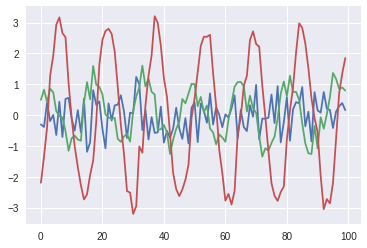

In [0]:
## 固有値の大きな3つの成分だけを見てみる
Z = tf.matmul(X, U[:, -3:])
plt.plot(Z.numpy())

#### 解釈
元々の信号は、殆どの成分がsin波（に小さなガウスノイズが乗ったもの）か、あるいはcos波（に小さなガウスノイズが乗ったもの）でした。sin波とcos波は互いに統計的に無相関になりますし、ガウスノイズとsin波（あるいはcos波）も無相関です。
すなわち、生成された多次元信号 $\bf X$ に関しては相関があるのは sin 波同士か、 cos 波同士しかありえません。主成分分析で無相関化された $\bf Z$ という多次元信号は元々相関があった信号をとある1つの成分に寄せ集めたものです。

すなわち、ある成分には sin 波が、ある成分には cos波 が集められ、そしてその2つの成分を除けば後は全て雑多な信号になっているはずです。当然、相関を持った信号が寄せ集められた結果、振幅は大きくなります。すなわち、その成分の分散は大きくなるということです。

このように意味のある信号がある成分に大きな分散を持って寄せ集まると信じれば（あるいはそのような性質の多次元信号を扱っているのであれば）、主成分分析での次元削減は有意義なものとなります。

　

#### 一般の場合
実際には $\bf X$ が時系列信号を並べた多次元信号で無くてもいいです。そもそも最初から画像のように $\bf X$という行列の形式を取ったデータでも構いません。画像を扱うならば、画像を縦に区切って各列を信号の如く扱い、他の列と相関がある列を寄せ集めて1つの列に集めているというイメージをすればいいです。

もし意味のある画像の列が主成分分析で保持できるとするならば、$\bf Z$という列を減らした画像（のようなもの）から再度 $\bf X$ を構築すれば、オリジナルの画像を良い精度で再構成できるはずです（逆に言えば$\bf Z$という容量の小さなデータで十分かもしれないということ） 。

ただし、無理に信号と絡める必要はありません。主成分分析は 行列$\bf X$ のユニタリ不変ノルムを最小化するという意味での低ランク近似としても定式化できます。ただ、そのような手順を取ったとしてもフロベニウスノルム最大化という観点で、特異値と固有値の関係（ $\bf X$ の特異値分解 と $\bf X^T X$の固有値分解の関係 ）を通して、今回の理解が必ず役立つでしょう。

### 確率的主成分分析
確率的主成分分析では、潜在変数 $\bf z \in \mathcal R^M$ があり、こちらが線形変換 $\bf W$ を受けて $\bf x \in \mathcal R^D$ になって私達の目に入る（観測する）という問題設定になります。また、この観測をするときには、$ \sigma^2$ の当方的分散をもつガウス分布としてバラツくと考えます。

$$
\bf x \sim \mathcal N\bf (Wz, \sigma^2I)
$$

潜在変数$\bf z$ はどこからやってくるのかというと、平均 $\bf 0$、分散 $\bf I$の当方的分散を持つガウス分布から生起していると考えます。すなわち

$$
\bf z \sim \mathcal N \bf (0, I)
$$

です。ここでパラメータ$\bf W$を最尤推定するのが確率的主成分分析です。この結果はよく知っている普通の主成分分析と同じになります（つまり対数尤度を最大化しようとした結果、例の固有値問題を解くことになる）。

###ベイズ主成分分析

ここでは一歩進めてベイズ主成分分析を見ましょう。$\bf W$に事前分布を適当に敷くことで、ベイズ主成分分析へと発展させられます。例えばPRMLでは下記のように事前分布を置く方法を紹介しています。

$$
{\bf W} \sim  \prod_{i=1}^M \left(\frac{\alpha_i}{2\pi} \right)^{D/2} \exp\left(-\frac{1}{2}\alpha_i {\bf w}_i^{\bf T} {\bf w}_i\right)
$$

ここで、${\bf w}_i$ は $\bf W$の $i$番目の列ベクトルです（すなわち${\bf W} = ({\bf w}_1, \cdots, {\bf w}_i, \cdots, {\bf w}_M )$である）。また $\bf W \in \mathcal R^{D\times M} $となっていることに注意してください。これは各列ベクトルが独立の異なるガウス分布から生起しているという問題設定です。更に周辺尤度最大化によるフルベイズでハイパーパラメータ$\alpha_i$の決定を行うこともでき、PRMLではEMアルゴリズムによってこれを導出しています。$\alpha_i$が非常に小さな値となれば、そのインデックス$i$に相当する${\bf w}_i$は自動で $0$ なるため、次元削減のために $M < D$ と選ばなくとも次元削減を行うことが可能です。

#### 今回の問題設定
今回はあまり小難しい推論は行わずに、下記のように適当な事前分布を敷いてしまいます。

$$
w_{dm} \sim \mathcal N(0, 4)
$$

ここで、$\bf W$の $d$ 行$ m$ 列の成分を $w_{dm}$ とします。要するに全部の成分が独立に分散 $4$ のガウス分布から生起しているという問題設定です。ちなみに、各成分がこのガウス分布から生起しているというのはかなり緩い事前分布です。なぜなら、$\bf W$ が直交行列であるだろうという主成分分析の背景を知っている我々にとって、各成分は$1$ 未満の小数点になっていると分かりきっていることだからです。それをわざわざ分散 $4$ の幅を持たせていることは無情報事前分布に等しいといえます。


In [0]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    ## 下記ではscaleは標準偏差を指定していることに注意
    W = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                scale=2.0 * tf.ones([data_dim, latent_dim]),
                name="W")  # parameter
    z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                scale=tf.ones([latent_dim, num_datapoints]), 
                name="z")  # parameter
    x = ed.Normal(loc=tf.matmul(W, z),
                scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
                name="x")  # (modeled) data
    return x, (W, z)



#### MAP推定
まずはMAP推定をしましょう。事後分布を最大化するようなパラメータを求めれば、MAP推定の完了です。事実上はやることとして最尤推定とさして代わりません（ただし観測データに依存しない事前分布の尤度に最適化が引っ張られるため、正則化の効果がある）。



In [0]:
data_dim = X.shape[1]
# print(data_dim)
latent_dim = 3
num_datapoints = X.shape[0]
# print(num_datapoints)
stddv_datapoints = 0.5

W = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

## X.shape == (num_data, data_dim)なので問題設定に合わせて転置する
x_train = tf.cast(tf.transpose(X), dtype=tf.float32)

## モデルの対数同時確率p(x, W, z)
log_joint = ed.make_log_joint_fn(probabilistic_pca)

## 部分適用でW, zの関数に
def target(W, z):
    return log_joint(data_dim=x_train.shape[0],
                     latent_dim=latent_dim,
                     num_datapoints=num_datapoints,
                     stddv_datapoints=stddv_datapoints,
                     W=W, z=z, x=x_train)



In [0]:
## 最小化問題へ
energy = -target(W, z)
optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(energy)

RandomVariable("W/", shape=(10, 3), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)


RuntimeError: ignored